# Sandbox: GraphConvAE

This notebook can be used for familiarization with the pytorch geometric package to train a GraphConvAE using a PPI as input.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import sys
import os
import random
import matplotlib.pyplot as plt
import community as community_louvain
from torch_geometric.data import Data
from torch import LongTensor, FloatTensor
from torch_geometric.utils import train_test_split_edges
import torch_geometric.transforms as T
import torch
from tqdm import tqdm
from torch_geometric.datasets import PPI, LastFMAsia, Planetoid
from torch_geometric.nn import GAE, GCNConv

sys.path.append("../../../")

from src.models.ae import GraphConvAE
from src.utils.basic.visualization import plot_train_val_hist

seed = 1234
np.random.seed(seed)
random.seed(seed)
%load_ext nb_black

<IPython.core.display.Javascript object>

---

## 1. Simple example

In the first simple example we will generate a simple graph containing 100 nodes and aim to learn an embedding after randomly assigning one feature to each of these nodes.

### 1.1. Graph setup

The generated graph is seen below colored using the Louvain community detection algorithm

In [2]:
graph = nx.read_gpickle(
    "/home/paysan_d/PycharmProjects/image2reg/data/ppi/ppi_confidence_pruned_0542_ccle_abslogfc_orf_maxp_spearmanr.pkl"
)

partition = community_louvain.best_partition(graph)


# pos = nx.spring_layout(graph, seed=seed)
# plt.figure(figsize=[15, 10])
# # nx.draw_networkx_edge_labels(graph,pos=pos,edge_labels=labels)
# nx.draw_networkx(graph, pos=pos, node_color=list(partition.values()), cmap="tab20")

<IPython.core.display.Javascript object>

In [3]:
nodes_dict = dict(zip(list(graph.nodes()), list(range(len(graph.nodes())))))
inv_nodes_dict = dict(zip(list(range(len(graph.nodes()))), list(graph.nodes())))
numeric_edge_list = []
for edge in graph.edges():
    numeric_edge_list.append((nodes_dict[edge[0]], nodes_dict[edge[1]]))
edge_idx = LongTensor(np.array(numeric_edge_list).transpose())
node_feat = FloatTensor(np.identity(len(graph.nodes())))


<IPython.core.display.Javascript object>

---

### 1.2 Data setup

Now we will derive the required quantities to describe the graph in form of torch.Tensors to make it applicable input for the pytorch_geometric package.

In [4]:
data = Data(x=node_feat, edge_index=edge_idx, edge_attr=None, pos=None)
data.train_mask = data.val_mask = data.test_mask = None
data

Data(edge_index=[2, 54550], x=[10841, 10841])

<IPython.core.display.Javascript object>

In [30]:
dataset = Planetoid("\..", "Cora", transform=T.NormalizeFeatures())
dataset.data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

<IPython.core.display.Javascript object>

In [31]:
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = None
# data.x = FloatTensor(np.identity(data.x.size(0)))

data

Data(edge_index=[2, 10556], x=[2708, 1433], y=[2708])

<IPython.core.display.Javascript object>

Next, we split the data into a training, validation and test set (0.7/0.1/0.2) as a size.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# transform = T.Compose([T.NormalizeFeatures()])
# data = transform(data).to(device)
data = data.to(device)
data_split = train_test_split_edges(data, val_ratio=0.1, test_ratio=0.2)
data_split

Data(test_neg_edge_index=[2, 10910], test_pos_edge_index=[2, 10910], train_neg_adj_mask=[10841, 10841], train_pos_edge_index=[2, 76370], val_neg_edge_index=[2, 5455], val_pos_edge_index=[2, 5455], x=[10841, 10841])

<IPython.core.display.Javascript object>

Let us construct 3 individual data sets for each portion to make the downstream analyses upwards compatible.

In [6]:
data_train = Data(x=data_split.x, edge_index=data_split.train_pos_edge_index)
data_train.edge_index = data_train.edge_index

data_val = Data(x=data_split.x, edge_index=data_split.val_pos_edge_index)
data_val.neg_edge_index = data.val_neg_edge_index

data_test = Data(x=data_split.x, edge_index=data_split.test_pos_edge_index)
data_test.neg_edge_index = data.test_neg_edge_index

data_dict = {"train": data_train, "val": data_val, "test": data_test}

<IPython.core.display.Javascript object>

---

### 1.3. Model setup

Next, we set up our Graph-convolutional Autoencoder as defined by Kipf & Welling (2016).

In [7]:
input_channels = data.num_features
hidden_dims = 1024
latent_dim = 256

model = GraphConvAE(
    input_channels=input_channels, hidden_dims=hidden_dims, latent_dim=latent_dim
)
model

GraphConvAE(
  (encoder): GCNEncoder(
    (gcn1): GCNConv(10841, 1024)
    (relu): ReLU()
    (gcn5): GCNConv(1024, 256)
  )
  (model): GAE(
    (encoder): GCNEncoder(
      (gcn1): GCNConv(10841, 1024)
      (relu): ReLU()
      (gcn5): GCNConv(1024, 256)
    )
    (decoder): InnerProductDecoder()
  )
)

<IPython.core.display.Javascript object>

In [8]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels)
        self.conv3 = GCNConv(2 * out_channels, 2 * out_channels)
        self.conv4 = GCNConv(2 * out_channels, 2 * out_channels)
        self.conv5 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        # x = self.conv2(x, edge_index).relu()
        # x = self.conv3(x, edge_index).relu()
        # x = self.conv4(x, edge_index).relu()
        return self.conv5(x, edge_index)

<IPython.core.display.Javascript object>

In [9]:
model.model = GAE(GCNEncoder(data.num_features, 128))

<IPython.core.display.Javascript object>

The GAE consists of two-layer graph-convolutional encoder that maps the node embedding from 1-16-8 dimensions. That is the latent space will be given by a euclidean 8 dimensional space. We apply a ReLU activation for nonlinearity after the first GCNConv layer.
The decoder is simply an innerproduct decoder that takes the sigmoid of the inner product of the latent embeddings for two nodes in order to compute a probabilistic adjacency matrix.

Next, we push everything to the GPU and define the Adam optimizer that we will use to train the model.

In [10]:
model = model.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

<IPython.core.display.Javascript object>

---

### 1.4. Model training

In [11]:
def process_single_epoch(model, data, mode, optimizer):
    if mode == "train":
        model.train()
        optimizer.zero_grad()
        latents = model(data.x, data.edge_index)["latents"]
        # Negative edges created via negative sampling
        loss = model.loss_function(latents, data.edge_index)
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        latents = model(data.x, data.edge_index)["latents"]
        loss = model.loss_function(latents, data.edge_index)

    return loss.item()


def test_gae(model, data):
    model.eval()
    latents = model.encode(data.x, data.edge_index)
    auc, ap = model.test(latents, data.edge_index, data.neg_edge_index)
    return auc, ap


def train_gae(model, data_dict, n_epochs=500, early_stopping=50):
    best_val_loss = np.infty
    loss_hist = {"train": [], "val": []}
    es_counter = 0

    best_model_weights = None
    best_epoch = -1

    for i in range(n_epochs):
        print("---" * 20)
        if es_counter < early_stopping:
            for mode in ["train", "val"]:
                loss = process_single_epoch(model, data_dict[mode], mode, optimizer)
                print("{} loss:".format(mode.upper()), loss)
                loss_hist[mode].append(loss)

                if mode == "val":
                    if loss < best_val_loss:
                        es_counter = 0
                        best_val_loss = loss
                        best_model_weights = model.state_dict()
                        best_epoch = i
                    else:
                        es_counter += 1
                    auc, ap = test_gae(model, data_dict[mode])
                    print("VAL AUC: {} \t AP: {}".format(auc, ap))
        else:
            print("Training stopped after {} epochs".format(i + 1))
            print("Best model found at epoch {}".format(best_epoch))
            break

    print("---" * 20)
    model.load_state_dict(best_model_weights)
    auc, ap = test_gae(model, data_dict["test"])
    print("TEST AUC: {} \t AP: {}".format(auc, ap))
    return model, loss_hist

<IPython.core.display.Javascript object>

In [12]:
model, loss_hist = train_gae(model, data_dict, n_epochs=300)
plot_train_val_hist(
    loss_hist["train"],
    loss_hist["val"],
    output_dir="/home/paysan_d/Desktop/",
    y_label="BCE",
)

------------------------------------------------------------
TRAIN loss: 1.3850550651550293
VAL loss: 1.3964385986328125
VAL AUC: 0.8817234921837784 	 AP: 0.861699458617749
------------------------------------------------------------
TRAIN loss: 1.178133249282837
VAL loss: 1.276670217514038
VAL AUC: 0.8842650937047638 	 AP: 0.8779742166534361
------------------------------------------------------------
TRAIN loss: 1.1163932085037231
VAL loss: 1.8252373933792114
VAL AUC: 0.8882702319872366 	 AP: 0.8801112792687258
------------------------------------------------------------
TRAIN loss: 1.2024539709091187
VAL loss: 1.1749392747879028
VAL AUC: 0.8863599603791038 	 AP: 0.8798798068121885
------------------------------------------------------------
TRAIN loss: 1.090909481048584
VAL loss: 1.155416488647461
VAL AUC: 0.89176157562794 	 AP: 0.8833709797979464
------------------------------------------------------------
TRAIN loss: 1.162872076034546
VAL loss: 1.1453025341033936
VAL AUC: 0.890191

TRAIN loss: 0.9842554330825806
VAL loss: 1.4944555759429932
VAL AUC: 0.8703327533582406 	 AP: 0.8738849820087469
------------------------------------------------------------
TRAIN loss: 0.9810248613357544
VAL loss: 1.5172204971313477
VAL AUC: 0.8734371631572713 	 AP: 0.8763577526360984
------------------------------------------------------------
TRAIN loss: 0.9726953506469727
VAL loss: 1.5606852769851685
VAL AUC: 0.8769798224116827 	 AP: 0.8791396951690269
------------------------------------------------------------
TRAIN loss: 0.9733514785766602
VAL loss: 1.5628703832626343
VAL AUC: 0.8803681987698704 	 AP: 0.881433777182679
------------------------------------------------------------
TRAIN loss: 0.9711484313011169
VAL loss: 1.5578023195266724
VAL AUC: 0.8826187093635872 	 AP: 0.8836299090212615
------------------------------------------------------------
TRAIN loss: 0.9640408158302307
VAL loss: 1.4975762367248535
VAL AUC: 0.8839027590963815 	 AP: 0.8846476570208543
------------------

<IPython.core.display.Javascript object>

After training the model we will now plot the embedding space and color it by the labels.

In [13]:
data_all = Data(x=node_feat, edge_index=edge_idx, edge_attr=None, pos=None)

<IPython.core.display.Javascript object>

In [51]:
data_all = Planetoid(root="/home/paysan_d/Downloads", name="Cora")[0]

<IPython.core.display.Javascript object>

In [14]:
latents = model(data_all.x.to(device), data_all.edge_index.to(device))["latents"]

<IPython.core.display.Javascript object>

In [15]:
zs = latents.cpu().detach().numpy()

<IPython.core.display.Javascript object>

In [16]:
from sklearn.preprocessing import StandardScaler

norm_zs = StandardScaler().fit_transform(zs)

<IPython.core.display.Javascript object>

In [17]:
norm_zs.shape

(10841, 128)

<IPython.core.display.Javascript object>

In [18]:
import umap

mapper = umap.UMAP(n_neighbors=10).fit(norm_zs)

<IPython.core.display.Javascript object>

<AxesSubplot:>

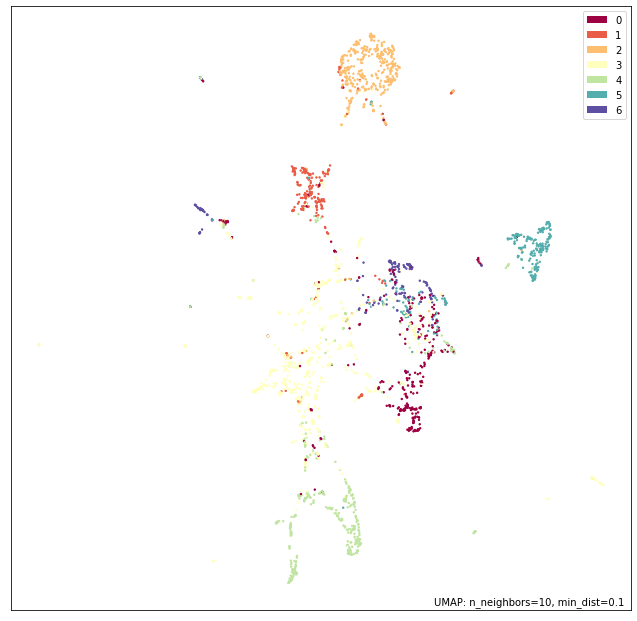

<IPython.core.display.Javascript object>

In [58]:
import umap.plot

umap.plot.points(mapper, labels=data_all.y.cpu().numpy())

<AxesSubplot:>

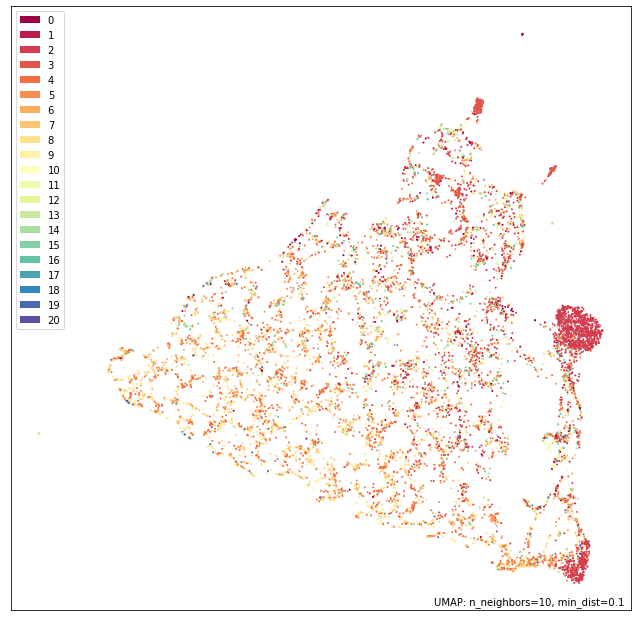

<IPython.core.display.Javascript object>

In [19]:
import umap.plot

umap.plot.points(mapper, labels=np.array(list(partition.values())))

In [89]:
from sklearn.manifold import TSNE

<IPython.core.display.Javascript object>

In [90]:
embs = TSNE().fit_transform(norm_zs)

<IPython.core.display.Javascript object>

In [91]:
import seaborn as sns

embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"])
#embs["label"] = list(partition.values())
sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", hue="label")

ValueError: Length of values (10841) does not match length of index (2708)

<IPython.core.display.Javascript object>